<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W1D3_ModelFitting/W1D3_Tutorial7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy: Week 1, Day 3, Tutorial 7
# Model Selection: AIC & cross validation

#Tutorial Objectives

This is Tutorial 7 of a series on fitting models to data. We start with simple linear regression, using least squares optimization (Tutorial 1) and Maximum Likelihood Estimation (Tutorial 2). We will use bootstrapping to build confidence intervals around the inferred linear model parameters (Tutorial 3). We'll finish our exploration of linear models by  generalizing to multiple linear regression (Tutorial 4). We then move on to polynomial regression (Tutorial 5). We end by learning how to choose between these various models. We discuss the bias-variance trade-off (Tutorial 6) and two common methods for model selection, AIC and Cross Validation (Tutorial 7).

In this tutorial, we will learn about model selection and two methods to accomplish model selection (AIC and cross-validation).

Tutorial objectives:

* Implement AIC and use it to compare polynomial regression models

* Implement cross-validation and use it to compare polynomial regression model

Video available at https://youtube.com/watch?v=EZAiR2frE7Y


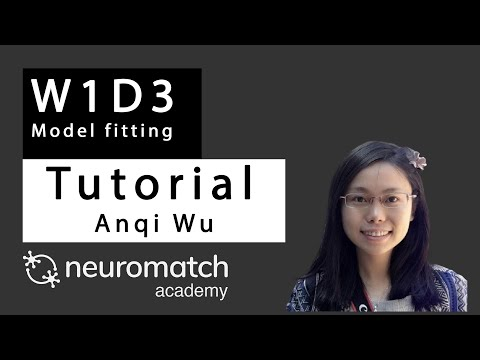

In [1]:
#@title Video Cross-Validation
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="EZAiR2frE7Y", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Setup

In [2]:
#@title  Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [3]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'

In [4]:
#@title Helper functions
def ordinary_least_squares(x, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vecto"r of measurements of shape (n_samples)
  
  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
  return np.linalg.inv(x.T @ x) @ x.T @ y

def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression
  
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    max_order (scalar): The order of the polynomial we want to fit

  Returns:
    numpy array: The design matrix containing x raised to different powers
  """

  # Broadcast to shape (n x 1) if shape (n, ) so this function generalizes to multiple inputs
  if x.ndim == 1:
    x = x[:,None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0],1)) 

  # Loop through rest of degrees and stack columns
  for degree in range(1, order+1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix


def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.
  
  Args:
    x (ndarray): An array of shape (samples, ) that contains the input values 
    y (ndarray): An array of shape (samples, ) that contains the output values
    max_order (scalar): The order of the polynomial we want to fit

  Returns:
    numpy array: (input_features, max_order+1) Each column contains the fitted 
    weights for that order of polynomial regression
  """

  # Create a dictionary with polynomial order as keys, and np array of theta 
  # (weights) as the values
  theta_hat = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order+1):

    X = make_design_matrix(x, order)
    this_theta = ordinary_least_squares(X, y)

    theta_hat[order] = this_theta

  return theta_hat


# Model Selection

We now have multiple choices for which model to use for a given problem: we could use linear regression, order 2 polynomial regression, order 3 polynomial regression, etc. As we saw in Tutorial 6, different models will have different quality of predictions, both on the training data and on the test data. We need to be able to choose between models without looking at any test data. In fact, we should never look at or use the test data in any way when modeling.  If we do, we would then be unable to report a true indication of how well the model generalizes to new data. We will cover two different methods for model selection in the next two sections. We will explore both methods using the same train/test data and polynomial regression models as in Tutorial 6 (generated below).

In [5]:
# You've seen this code before!

### Generate training data
np.random.seed(0)
n_samples = 50
x_train = np.random.uniform(-2, 2.5, n_samples) # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_samples) # sample from a standard normal distribution
y_train =  x_train**2 - x_train - 2 + noise

### Generate testing data
n_samples = 20
x_test = np.random.uniform(-3, 3, n_samples) # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_samples) # sample from a standard normal distribution
y_test =  x_test**2 - x_test - 2 + noise

### Fit polynomial regression models
max_order = 5
theta_hat = solve_poly_reg(x_train, y_train, max_order)

## Akaike's Information Criterion (AIC)

In order to choose the best model for a given problem, we can ask how likely the data is under a given model. We want to choose a model that assigns high probability to the data. A commonly used method for model selection that uses this approach is **Akaike’s Information Criterion (AIC)**.

Essentially, AIC estimates how much information would be lost if the model predictions were used instead of the true data (the relative information value of the model). We compute the AIC for each model and choose the model with the lowest AIC. Note that AIC only tells us relative qualities, not absolute - we do not know from AIC how good our model is independent of others.

AIC strives for a good tradeoff between overfitting and underfitting by taking into account the complexity of the model and the information lost. AIC is calculated as:

$$ AIC = 2K - 2 log(L)$$

where K is the number of parameters in your model and L is the likelihood that the model could have produced the output data. 


### AIC for Polynomial Regression

Now we know what AIC is, we want to use it to pick between our polynomial regression models. We haven't been thinking in terms of likelihoods though - so how will we calculate L? 

As we saw in Tutorial 2, there is a link between mean squared error and the likelihood estimates for linear regression models that we can take advantage of. 

*Derivation time!*

We start with our formula for AIC from above:

$$ AIC = 2k - 2 log L $$

For a model with normal errors, we can use the log likelihood of the normal distribution:

$$ \log L = -\frac{n}{2} \log(2 \pi) -\frac{n}{2}log(\sigma^2) - \sum_i^n \frac{1}{2 \sigma^2} (y_i - \tilde y_i)^2$$

We can drop the first and last terms as both are constants and we're only assessing relative information with AIC. Once we drop those terms and incorporate into the AIC formula we get:

$$AIC = 2k + nlog(\sigma^2)$$

We can replace $\sigma^2$ with the computation for variance (the sum of squared errors divided by number of samples). Thus, we end up with the following formula for AIC for linear and polynomial regression:

$$ AIC = 2K + n log(\frac{SSE}{n})$$

where k is the number of parameters, n is the number of samples, and SSE is the summed squared error.


#### Exercise: Compute and compare AIC

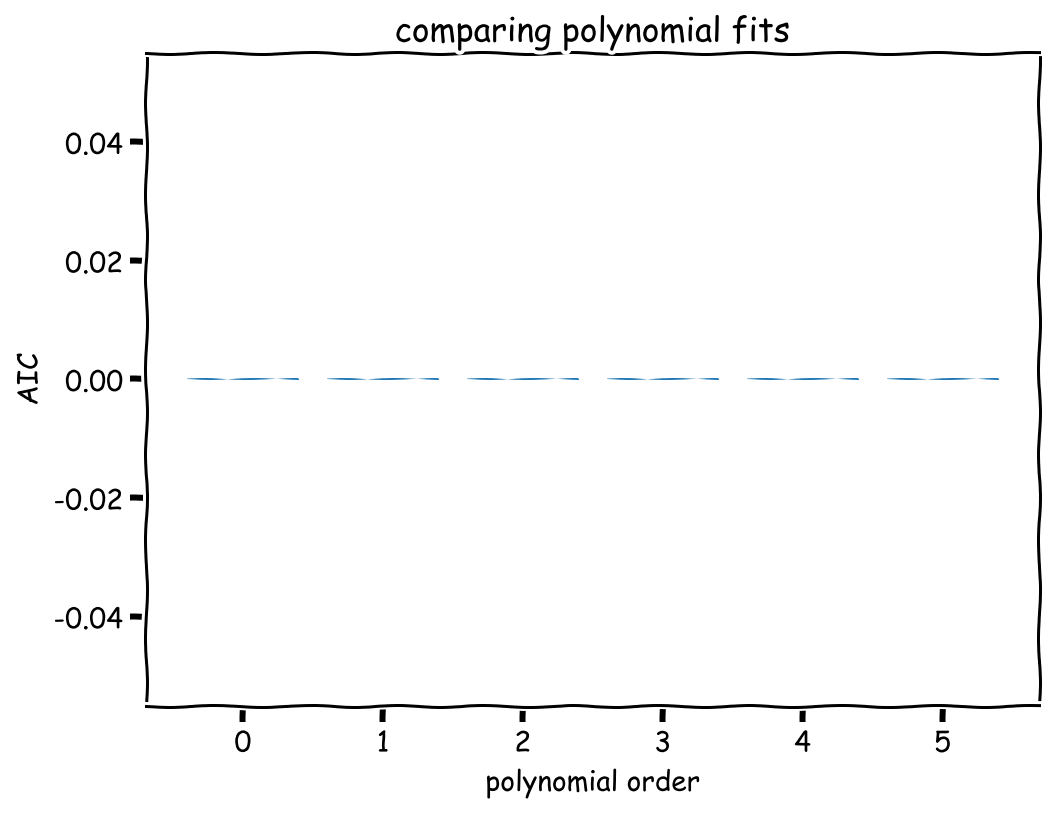

In [6]:
AIC = np.zeros((max_order+1))
for order in range(0, max_order+1):

  # Compute predictions for this model 
  X_design = make_design_matrix(x_train, order)
  y_hat = np.dot(X_design, theta_hat[order])

  #####################################################################################################
  ## TODO for students: Compute AIC for this order polynomial regression model
  # 1) Compute sum of squared errors given prediction y_hat and y_train (SSE in formula above)
  # 2) Identify number of parameters in this model (K in formula above)
  # 3) Compute AIC (call this_AIC) according to formula above
  #####################################################################################################

    # Compute SSE
    #residuals = YOUR CODE HERE
    #sse = YOUR CODE HERE

    # Get K
    #K = len(theta_hat[order])


    # Compute AIC
    # AIC[order] = ...

with plt.xkcd():
  plt.bar(range(max_order+1), AIC);
  plt.ylabel('AIC')
  plt.xlabel('polynomial order')
  plt.title('comparing polynomial fits')
  plt.show()

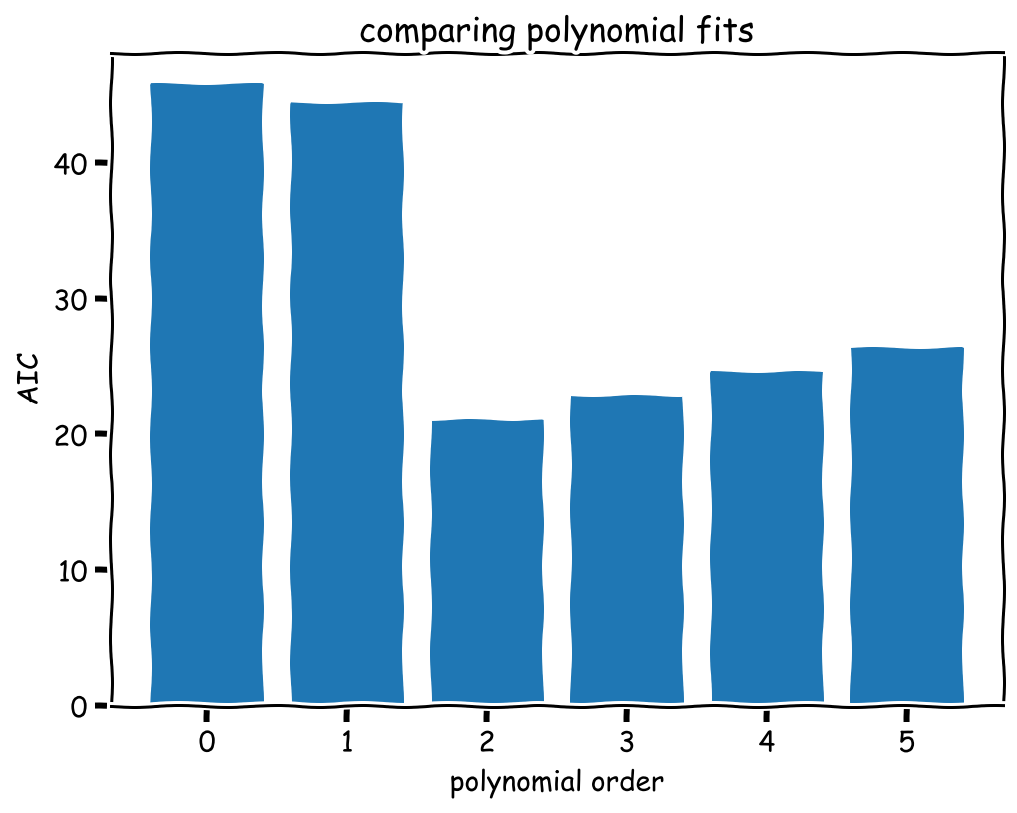

In [7]:
# to_remove solution

AIC = np.zeros((max_order+1))
for order in range(0, max_order+1):

  # Compute predictions for this model 
  X_design = make_design_matrix(x_train, order)
  y_hat = np.dot(X_design, theta_hat[order])

  # Compute SSE
  residuals = y_train - y_hat
  sse = np.sum(residuals ** 2)

  # Get K
  K = len(theta_hat[order])

  # Compute AIC
  AIC[order] = 2*K + n_samples * np.log(sse/n_samples)

with plt.xkcd():
  plt.bar(range(max_order+1), AIC);
  plt.ylabel('AIC')
  plt.xlabel('polynomial order')
  plt.title('comparing polynomial fits')
  plt.show()

Which model would we choose based on AIC? 

## Cross Validation

AIC is just one method for model selection - another commonly used method is **cross validation**. AIC gives a measure of how likely the training data is given the model. Cross-validation takes a different approach to the model selection problem and asks how well the model predicts new data that it hasn't seen yet. 

Instead of looking at test data, we want to use held-out data set that will not be used for the final evaluation, **validation data**. We often have a limited amount of data though (especially in neuroscience), so we do not want to further reduce our potential training data by reassigning some as validation. Luckily, we can use **k-fold cross-validation**! In k-fold cross validation, we divide up the data into k subsets, train a model on k-1 subsets, and compute error on the held-out subset (our validation data). In total, we train k instances of each model. Each of these k instances has a different subset excluded from fitting and labeled as validation. We then average the error of each of the k trained models on its validation subset - this is the validation error of this model type. 

To make this explicit, let's say we have 1000 samples of training data and choose 4-fold cross-validation. Samples 0 - 250 would be subset 1, samples 250 - 500 subset 2, samples 500 - 750 subset 3, and samples 750-1000 subset 4. First, we train an order 3 polynomial regression on subsets 1,2,3 and evaluate on subset 4. Next, we train an order 3 polynomial model on subsets 1,2,4 and evalute on subset 3. We continue until we have 4 instances of a trained order 3 polynomial regression model, each with a different subset as validation data, and average the validation error from each instance.

We can now compare the validation error of different models to pick a model that generalizes well to held-out data. We can choose the measure of prediction quality to report error on the validation subsets to suit our purposes. We will use MSE here but we could also use log likelihood of the data and so on. As a final step, we retrain this model on all of the training data (without subset divisions) to get our final model that we will evaluate on test data. This approach allows us to evaluate the quality of predictions on new data without sacrificing any of our precious training data. 

These steps are summarized in this diagram from SkLearn (https://scikit-learn.org/stable/modules/cross_validation.html)


![Diagram from Sklearn](https://scikit-learn.org/stable/_images/grid_search_workflow.png)



Importantly, we need to be very careful when dividing the data into subsets.  The validation subset should not be used in any way to fit the model. We should not do any preprocessing (e.g. normalization) before we divide into subsets or the validation subset could influence the training subsets. A lot of false-positives in crossvalidation come from wrongly dividing. 

An important consideration in the choice of model selection method are the relevant biases. If we just fit using MSE on training data, we will generally find that fits get better as we add more parameters because the model will overfit the data, as we saw in Tutorial 6. When using cross-validation, the bias is the other way round. Models with more parameters are more affected by noise so cross-validation will generally prefer models with fewer parameters.




### Exercise: implement cross-validation

Given our set of models to evaluate (polynomial regression models with orders 0 through 5), we will use cross-validation to determine which model has the best predictions on new data according to MSE. 

In this code, we split the data into 10 subsets using `Kfold` (from `sklearn.model_selection`). `KFold` handles cross-validation subset splitting and train/val assignments.  In particular, the `Kfold.split` method returns an iterator which we can loop through. On each loop, this iterator assigns a different subset as validation and returns new training and validation indices with which to split the data. 

We will loop through the 10 train/validation splits and fit several different polynomial regression models (with different orders) for each split. You will need to use the `solve_poly_reg` method from Tutorial 5 (already implemented in this notebook).

In [8]:
def cross_validate(x_train,y_train,max_order,n_splits):

  # Initialize the split method
  kfold_iterator = KFold(n_splits)

  # Initialize np array mse values for all models for each split
  mse_all = np.zeros((n_splits, max_order+1))

  for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(x_train)):
      
      # Split up the overall training data into cross-validation training and validation sets
      x_cv_train = x_train[train_indices]
      y_cv_train = y_train[train_indices]
      x_cv_val = x_train[val_indices]
      y_cv_val = y_train[val_indices]

    #############################################################################
    ## TODO for students: Fill in missing ... in code below to choose which data
    ## to fit to and compute MSE for
    #############################################################################

      ## Fit models
      #theta_hat = YOUR CODE HERE

      # Compute MSE
      mse_this_split = np.zeros((max_order+1))
      #for order in range(0, max_order+1):
        #X_design= 
        #y_hat = )
        #mse_this_split[order] = 

      #mse_all[i_split] = mse_this_split

  #comment this line once you've filled in the function
  raise NotImplementedError("Student excercise: implement cross-validation")
  return mse_all

In [9]:
# to_remove solution
def cross_validate(x_train,y_train,max_order,n_splits):

  # Initialize the split method
  kfold_iterator = KFold(n_splits)

  # Initialize np array mse values for all models for each split
  mse_all = np.zeros((n_splits, max_order+1))

  for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(x_train)):
      
      # Split up the overall training data into cross-validation training and validation sets
      x_cv_train = x_train[train_indices]
      y_cv_train = y_train[train_indices]
      x_cv_val = x_train[val_indices]
      y_cv_val = y_train[val_indices]

      # Fit models
      theta_hat = solve_poly_reg(x_cv_train, y_cv_train, max_order)

      # Compute MSE
      mse_this_split = np.zeros((max_order+1))
      for order in range(0, max_order+1):
        X_design= make_design_matrix(x_cv_val, order)
        y_hat = np.dot(X_design, theta_hat[order])
        mse_this_split[order] = np.mean((y_cv_val - y_hat) ** 2)

      mse_all[i_split] = mse_this_split

  #comment this line once you've filled in the function
  #raise NotImplementedError("Student excercise: implement cross-validation")
  return mse_all


Use the following code to visualize the cross-validated MSE. Which polynomial order do you think is a better model of the data?

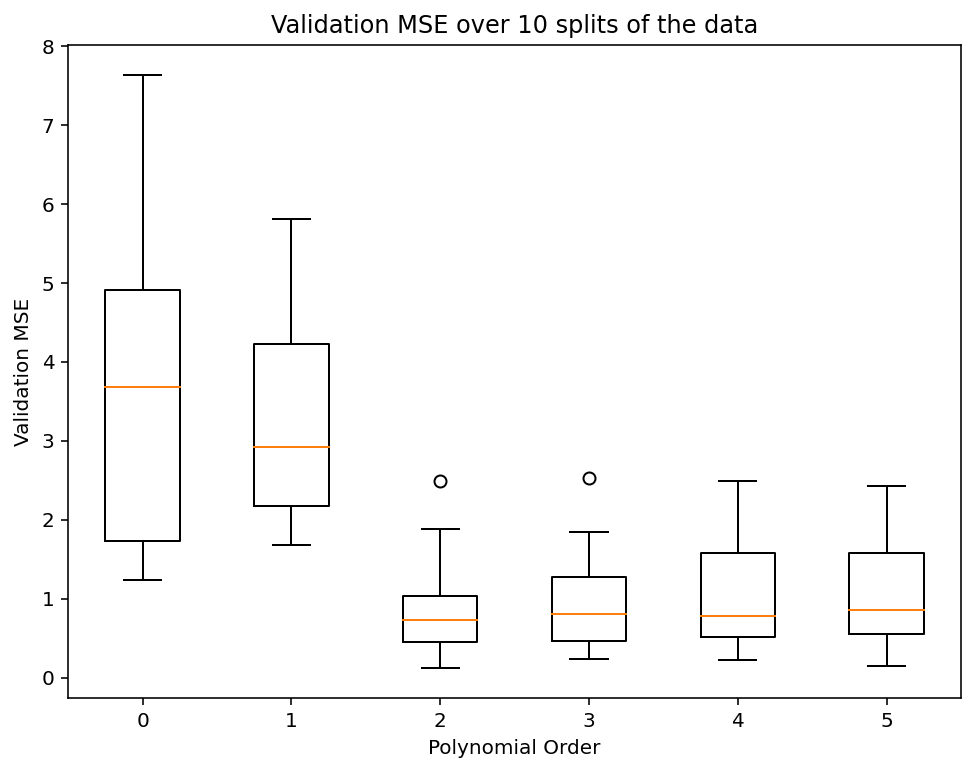

In [10]:
max_order = 5
n_splits = 10
mse_all = cross_validate(x_train,y_train,max_order,n_splits)

plt.figure()
plt.boxplot(mse_all, labels=np.arange(0,max_order+1))
plt.xlabel('Polynomial Order')
plt.ylabel('Validation MSE')
plt.title(f'Validation MSE over {n_splits} splits of the data');

Which model would you choose based on cross-validation? Is it the same or different than what you would choose based on AIC?

# Summary

We need to use model selection methods, such as AIC and cross-validation, to determine the best model to use for a given problem. 

AIC focuses on how likely the data is given the model. 

Cross-validation focuses on how well the model predicts new data.